# Introduction <a name="introduction"></a>

In this study, we analyzed data that directly provided interbeat intervals between consecutive heartbeats. To process these data, we first computed the cumulative heartbeat time series and divided it into segments. Next, polynomials of specific degrees were fitted to each segment to extract potential trends.

We then computed the probability density function (PDF) of heart rate changes and compared it with a Gaussian distribution. Additionally, we examined the cascade model as a possible descriptor of heart rate variability. However, our findings generally indicated that these models did not adequately align with the observed data. Ultimately, the results of this study suggest that heart rate variability exhibits self-similarity and scale invariance, resembling the characteristics of a critical system rather than a cascade model.

# Imported libraries <a name="imported_libraries"></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import pandas as pd
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.integrate import quad_vec


In [11]:
data_name = ["000","002","003","005","006","008","009","010","011","013"]
data_files = ["000","002","003","005","006","008","009","010","011","013"]
dict = {}
for i in data_files:
    f = open("data/" + i + ".txt","r")
    data0 = []

    for line in f.readlines():
        x = line.strip()
        if x:
            data0.append(int(x))
        dict[i] = data0
df = pd.DataFrame.from_dict(dict, orient="index")

In [5]:
df

0       1       2       3       4       5       6       7       8       \
000     789     727     789     750     812     789     828     797     867   
002     735     781     742     680     758     695     680     679     625   
003     718     672     688     672     664     625     617     617     617   
005     797     843     829     828     859     859     875     875     922   
006     844     813     781     773     789     797     797     758     727   
008     758     774     789     781     687     672     680     727     836   
009     641     633     640     657     648     649     632     633     641   
010     984     969     969     922     937     961     992    1000     930   
011     539     539     547     539     539     531     539     539     539   
013     664     665     656     672     672     656     656     641     601   

     9       ...  111511  111512  111513  111514  111515  111516  111517  \
000     860  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
002     657  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
003     633  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
005     875  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
006     703  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
008     914  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
009     625  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
010     914  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
011     539  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
013     610  ...   609.0   610.0   625.0   617.0   617.0   649.0   648.0   

     111518  111519  111520  
000     NaN     NaN     NaN  
002     NaN     NaN     NaN  
003     NaN     NaN     NaN  
005     NaN     NaN     NaN  
006     NaN     NaN     NaN  
008     NaN     NaN     NaN  
009     NaN     NaN     NaN  
010     NaN     NaN     NaN  
011     NaN     NaN     NaN  
013   641.0   632.0   632.0  

[10 rows x 111521 columns]

In [6]:
#detrending, standardizing and creating the inrements series

def detr_and_standardize(b_i, s):
    B = np.cumsum(b_i)
    dict = {}
    
    for i in range(len(s)):
        k = s[i]
        c = int(len(B) / (2 * k))

        detrends = []

        for i in range(c):
            section = B[i*2*k:(i+1)*2*k]
            x = np.arange(len(section))
            
            degree = 3
            p = Polynomial.fit(x, section, degree) 
            trend = p(x) 
            detrended_data = section - trend
            detrends.append(detrended_data)
            
            for j in range(2*k):
                    if k in dict:
                        dict[k].append(detrends[i][j])
                    else:
                        dict[k] = []
    deltaB = {}

    # take the increments
    for l in s:
        arr = np.array(dict[l])
        diff = (arr[:-(l + 1)] - arr[(l + 1):]) / np.std(dict[l])
        deltaB[l] = diff
 
    dataframe = pd.DataFrame.from_dict(deltaB, orient = 'index')

    return dataframe

first, take cumsum, then divide cumsum into segments based on time scale. Then, detrend each segment and combinde detrended segments together. then, take the increments based on time scales

In [7]:
#initializing the scales
s_list = np.array([10,25,125,500,1000,1500])

In [8]:
#making a list of dataframes that contain the increments series for evey scale
deltaBs = []

for i in range(len(df)):
    row = df.iloc[i]
    data = row.to_numpy()
    data = data[~np.isnan(data)]
    deltaB = detr_and_standardize(data, s_list)
    deltaBs.append(deltaB)

In [9]:
deltaBs

[         0         1         2         3         4         5         6      \
 10   -0.842307  0.399861  0.220572  1.507701 -0.269274 -0.367875 -0.854658   
 25   -0.558780 -0.445330 -1.003850 -0.570618  0.005353  0.183782 -0.181122   
 125   1.941746  1.796474  1.648181  1.548563  1.485947  1.458664  1.311629   
 500   2.915108  2.813107  2.711250  2.618585  2.516620  2.427389  2.320201   
 1000  0.050134  0.011317 -0.031916 -0.061653 -0.101970 -0.130139 -0.167154   
 1500 -1.228231 -1.237477 -1.248641 -1.257904 -1.269221 -1.274135 -1.275783   
 
          7         8         9      ...     80418    80419     80420  \
 10   -0.696345  0.654014  2.034477  ... -0.271151  0.62634  0.038744   
 25    0.522910  0.760792  0.721195  ...       NaN      NaN       NaN   
 125   1.304986  1.557135  1.517768  ...       NaN      NaN       NaN   
 500   2.228108  2.154652  2.078191  ...       NaN      NaN       NaN   
 1000 -0.189325 -0.217260 -0.251537  ...       NaN      NaN       NaN   
 1500 -

## Gaussian fit <a name="gauss"></a>

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_1816/1993828257.py:38: RuntimeWarning: divide by zero encountered in log10
  residuals = np.log10(hist_plot) - np.log10(fit)


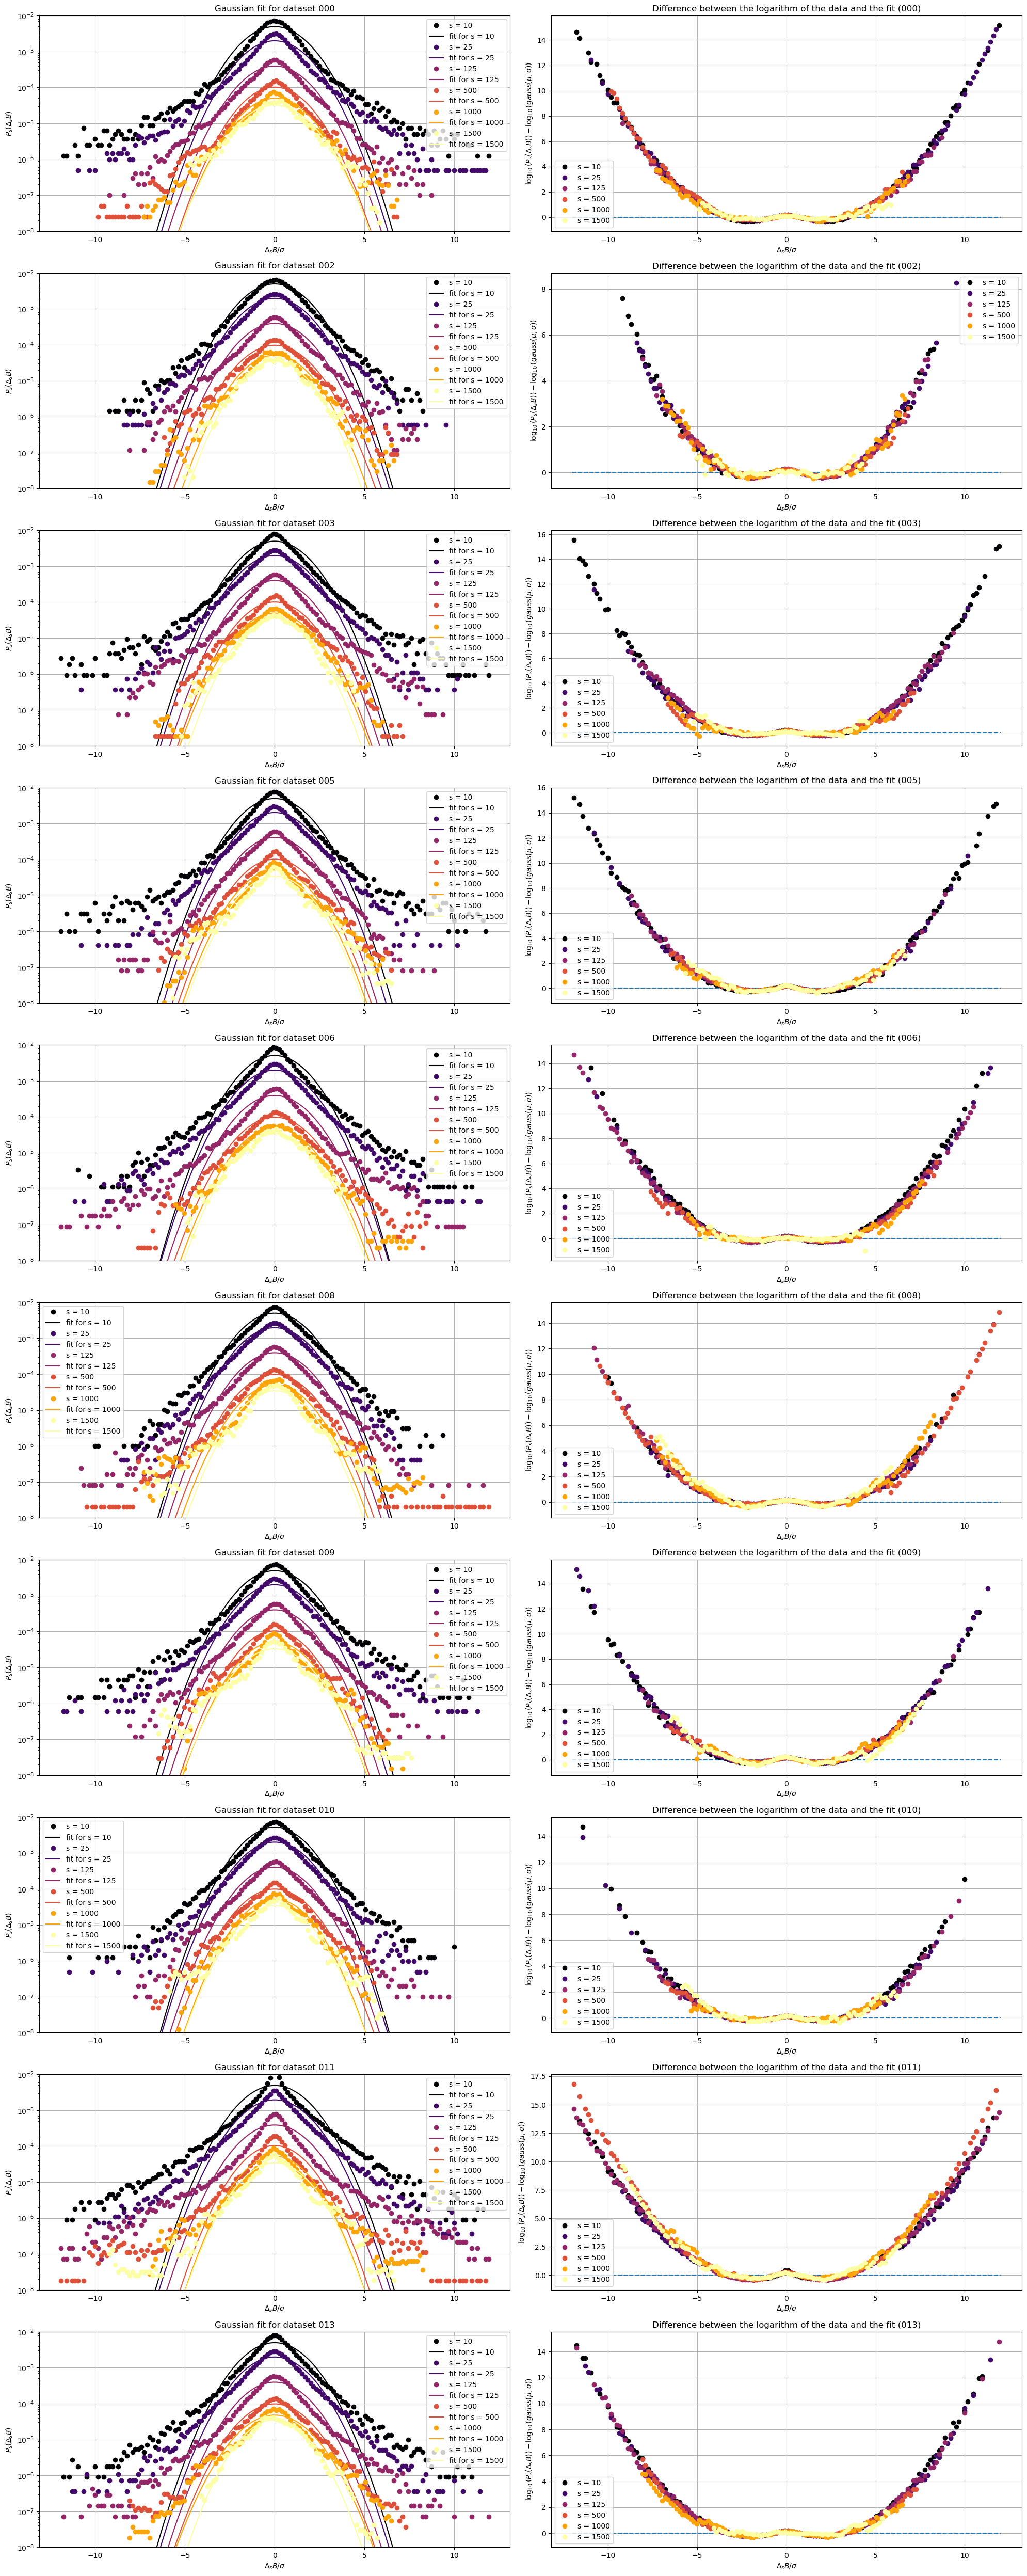

In [12]:
fig, axes = plt.subplots(10, 2, figsize=(20, 50))
colors = plt.cm.inferno(np.linspace(0, 1, len(s_list)))

for i in range(len(deltaBs)):
    ax_left = axes[i, 0] #plot of the Gaussian distribution 
    ax_right = axes[i, 1] #plot of the residuals
    
    ax_left.set_yscale('log') #logharitmic scale
    ax_left.set_ylim(1e-8, 1e-2)
    ax_right.hlines(0, -12, 12, linestyles="dashed")
    ax_left.grid(True)
    ax_right.grid(True)
    ax_left.set_title(f"Gaussian fit for dataset {data_name[i]}")
    ax_right.set_title(f"Difference between the logarithm of the data and the fit ({data_name[i]})")
    ax_left.set_xlabel(r"$\Delta_s B / \sigma$")
    ax_left.set_ylabel(r"$P_s (\Delta_s B)$")
    ax_right.set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(gauss(\mu, \sigma))$")
    ax_right.set_xlabel(r"$\Delta_s B / \sigma$")
    
    for j in range(len(s_list)):
        scale = s_list[j] #time scale 
        data = deltaBs[i].iloc[j].to_numpy() #convert to numpy array
        points = data[~np.isnan(data)] #remove NaN values
        
        # plot the Gaussian
        hist, bins = np.histogram(points, bins=150, range=(-12, 12))
        centers = (bins[:-1] + bins[1:]) / 2
        
        mu, sigma = norm.fit(points)
        fit = norm.pdf(centers, mu, sigma)
        fit = fit / (np.sum(fit) * scale)
        
        hist_plot = hist / (scale * np.sum(hist))
        ax_left.plot(centers, hist_plot, 'o', color=colors[j], label=f"s = {scale}")
        ax_left.plot(centers, fit, color=colors[j], label=f"fit for s = {scale}")
        
        # plot the residuals
        residuals = np.log10(hist_plot) - np.log10(fit)
        ax_right.plot(centers, residuals, 'o', color=colors[j], label=f"s = {scale}")
    
    ax_left.legend()
    ax_right.legend()

plt.tight_layout()
plt.show()


The result shows that the human heart rate does not fit Gaussian distribution since it has fat tails.

**Key Observations:**


*   Around the center (0 on the x-axis), residuals are small, meaning the Gaussian approximation is good.

*   At both extremes (large positive/negative ΔsBΔs​B), residuals increase, meaning the Gaussian function underestimates the probability of extreme fluctuations.

*  The dashed black horizontal line at 0 indicates the ideal case where the fit perfectly matches the data.


## Castaing fit <a name="castaing"></a>

Castaing's equation:
$$
\tilde{P}_s(x) = \int_{0}^{+\infty}\frac{1}{\sigma \sqrt{2\pi}} exp(-\frac{x^2}{2\sigma^2}){\frac{1}{\lambda \sqrt{2\pi}} exp(- \frac{ln^2 (\sigma)}{2\lambda^2}) \frac{d\sigma}{\sigma}}
$$

In [13]:
# Define the Castaing function
def Castaing_func(x, lambd):
    def integrand(sigma, x, lambd):
        return 1 / (2 * np.pi * lambd * sigma ** 2) * np.exp(
            - (x ** 2 / sigma ** 2 + np.log(sigma) ** 2 / lambd ** 2) / 2
        )
    # Integrate from 0 to infinity
    results = quad_vec(integrand, 1e-6, np.inf, args=(x, lambd))[0]
    return results
Castaing = np.vectorize(Castaing_func)

Dataset 000
Dataset 002
Dataset 003
Dataset 005
Dataset 006
Dataset 008
Dataset 009
Dataset 010
Dataset 011
Dataset 013


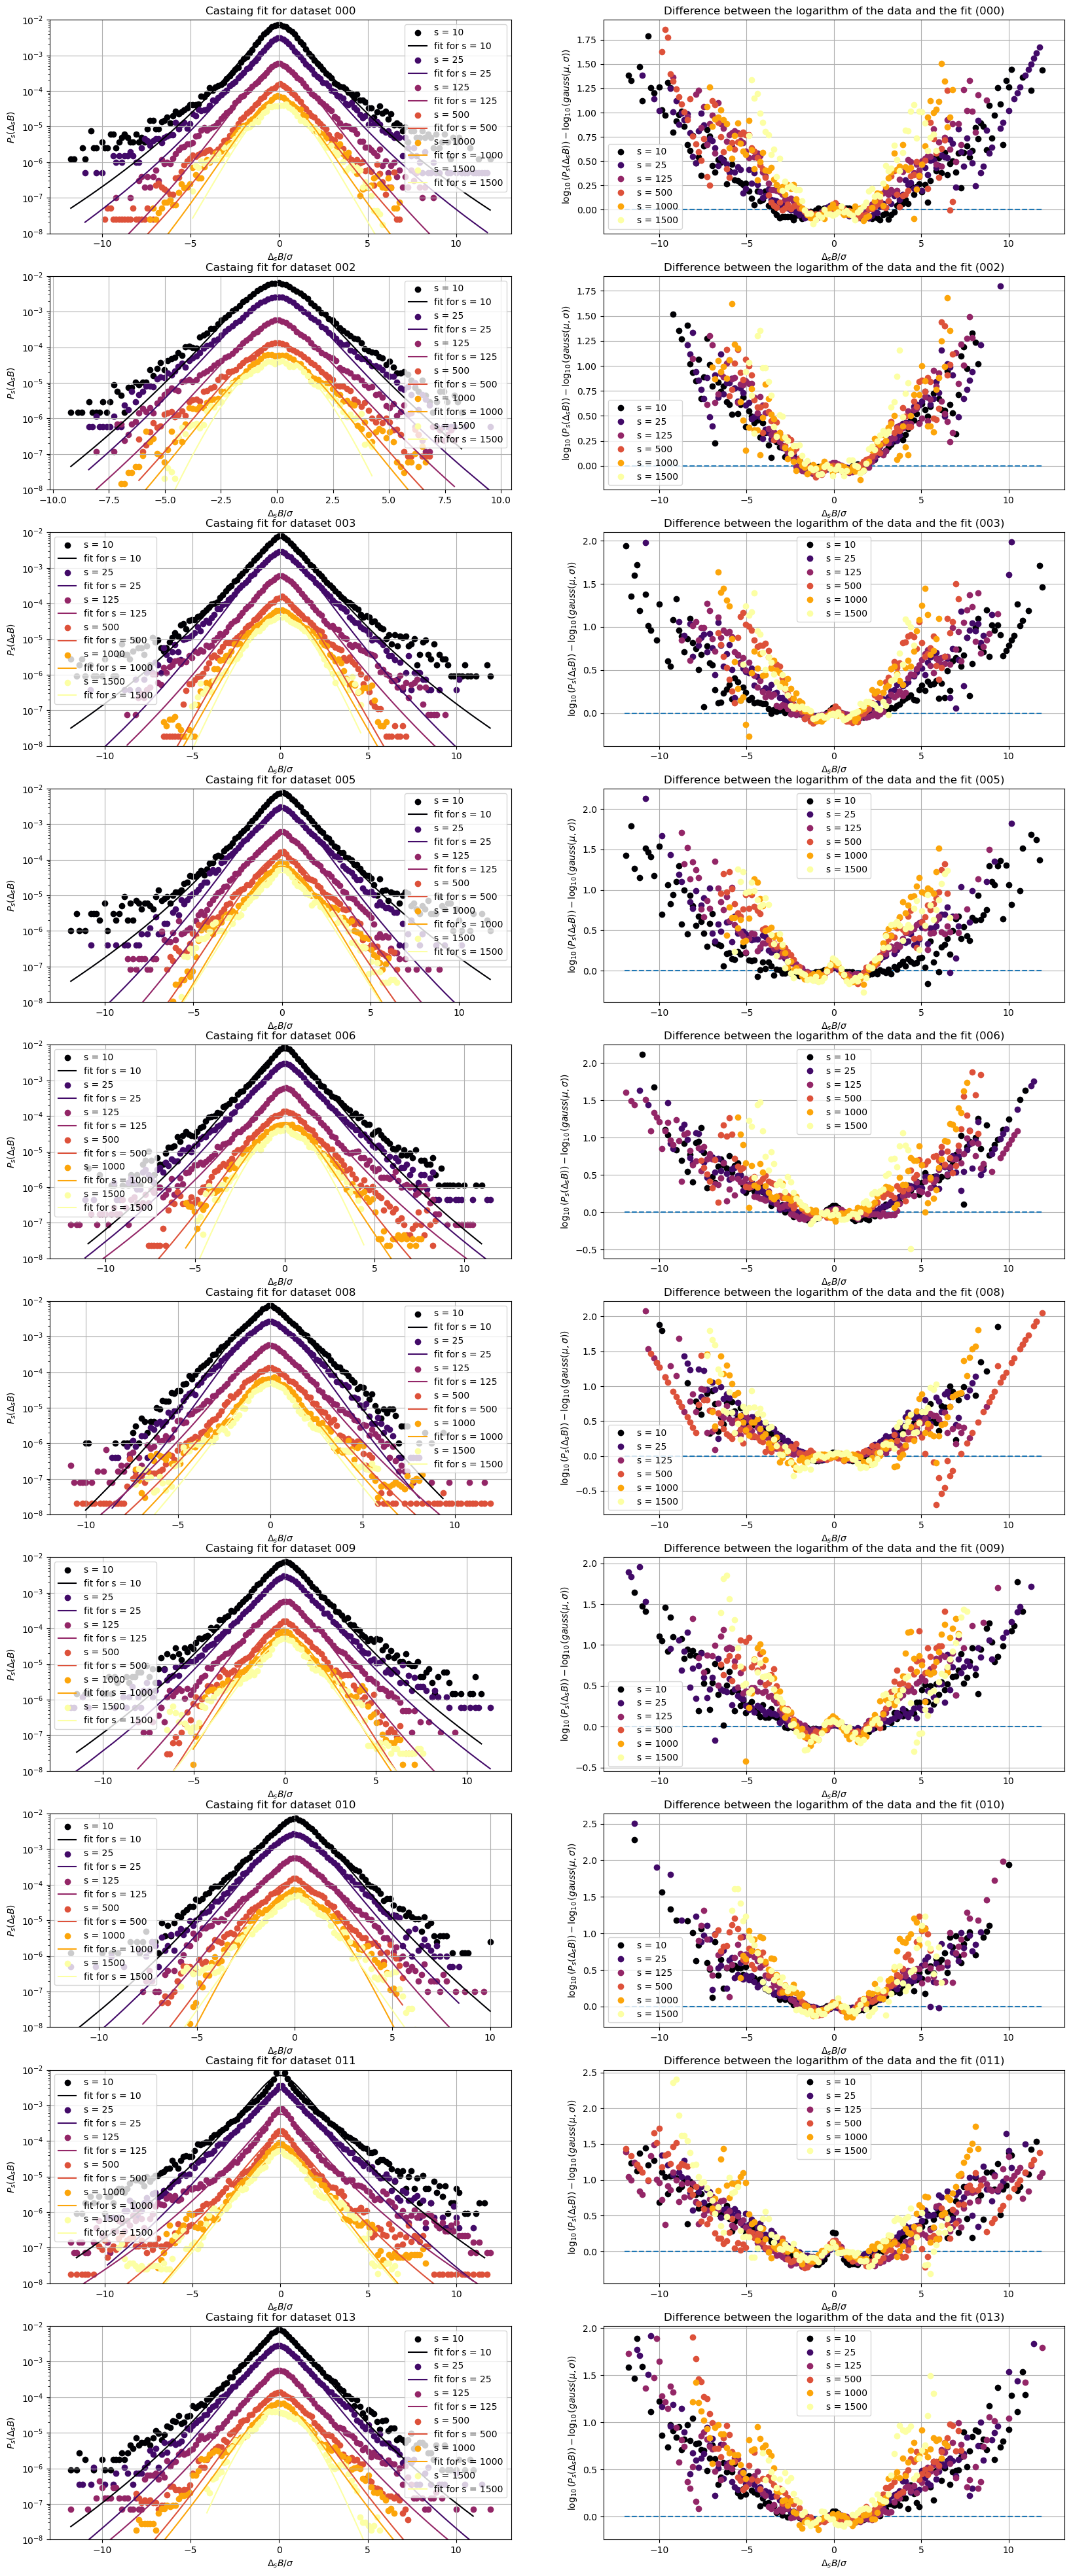

In [14]:
#Plotting the data against the fit and the residuals

fig, axes = plt.subplots(10, 2, figsize=(20, 50))
colors = plt.cm.inferno(np.linspace(0, 1, len(s_list)))
lambda_all = []
lambda_err_all = []

for i in range(len(deltaBs)):
    ax_left = axes[i, 0]
    ax_right = axes[i, 1]

    ax_left.set_yscale('log')
    ax_left.set_ylim(1e-8, 1e-2)
    ax_right.hlines(0, -12, 12, linestyles="dashed")
    ax_left.grid(True)
    ax_right.grid(True)
    ax_left.set_title(f"Castaing fit for dataset {data_name[i]}")
    ax_right.set_title(f"Difference between the logarithm of the data and the fit ({data_name[i]})")
    ax_left.set_xlabel(r"$\Delta_s B / \sigma$")
    ax_left.set_ylabel(r"$P_s (\Delta_s B)$")
    ax_right.set_xlabel(r"$\Delta_s B / \sigma$")
    ax_right.set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(gauss(\mu, \sigma))$")

    lambdas = np.zeros(len(s_list))
    lambdas_err = np.zeros(len(s_list))

    print(f"Dataset {data_name[i]}")
    
    for j in range(len(s_list)):
        scale = s_list[j]
    
        data = deltaBs[i].iloc[j].to_numpy()
        points = data[~np.isnan(data)]
        hist, bins = np.histogram(points, bins=150, range=(-12, 12))

        # Exclude bins with zero counts.
        mask = hist != 0
        centers = (bins[:-1] + bins[1:]) / 2
        centers = centers[mask]
        hist = hist[mask]
        
        # Fit the Castaing function to the data
        parameters, cov = curve_fit(
            lambda x, lambd: np.log10(Castaing(x, lambd) / np.trapz(Castaing(x, lambd), x)),
            centers,
            np.log10(hist / np.sum(hist)),
            p0=0.6,
            bounds=[0.1, 1]
        )
        
        #print("Lambda=", scale, ":", parameters[0])
        
        fit_c = Castaing(centers, parameters[0])
        fit_c = fit_c / (np.sum(fit_c) * scale)
        
        hist_plot = hist / (scale * np.sum(hist))
        ax_left.scatter(centers, hist_plot, color=colors[j], label=f"s = {scale}")
        ax_left.plot(centers, fit_c, color=colors[j], label=f"fit for s = {scale}")
        
        residuals = np.log10(hist_plot) - np.log10(fit_c)
        ax_right.plot(centers, residuals, 'o', color=colors[j], label=f"s = {scale}")
        
        std = np.sqrt(cov[0, 0])

        lambdas[j] = parameters[0]
        lambdas_err[j] = std

    lambda_all.append(lambdas)
    lambda_err_all.append(lambdas_err)

    ax_left.legend()
    ax_right.legend()
plt.show()

The plots clearly show that Castaing's function is a good fit for all 10 datasets

In [ ]:
print(lambda_all)

[array([0.42492498, 0.39961915, 0.33706608, 0.3409424 , 0.29745841,
       0.24221401]), array([0.33071044, 0.32172172, 0.31823385, 0.28543978, 0.26467531,
       0.13844152]), array([0.41090026, 0.33817937, 0.35052138, 0.23279424, 0.23232815,
       0.18897765]), array([0.41857316, 0.33125832, 0.30725212, 0.27678863, 0.24556025,
       0.25986373]), array([0.37422619, 0.37950616, 0.40613753, 0.31731272, 0.27006085,
       0.16552837]), array([0.32198681, 0.2988741 , 0.3686555 , 0.36892405, 0.34682004,
       0.32183954]), array([0.39858645, 0.3880931 , 0.32334287, 0.25351153, 0.26288769,
       0.30777114]), array([0.3449694 , 0.33131783, 0.30942317, 0.27373998, 0.18755512,
       0.26464629]), array([0.4210647 , 0.37829426, 0.44521631, 0.4127862 , 0.32920241,
       0.34420709]), array([0.39490322, 0.36632969, 0.38342091, 0.31802555, 0.31353316,
       0.16831679])]


In [ ]:
print(lambda_err_all)

[array([0.01006439, 0.0090354 , 0.01003599, 0.01064555, 0.01283968,
       0.0198579 ]), array([0.00941437, 0.00944672, 0.01122476, 0.01447143, 0.01234596,
       0.02308623])]


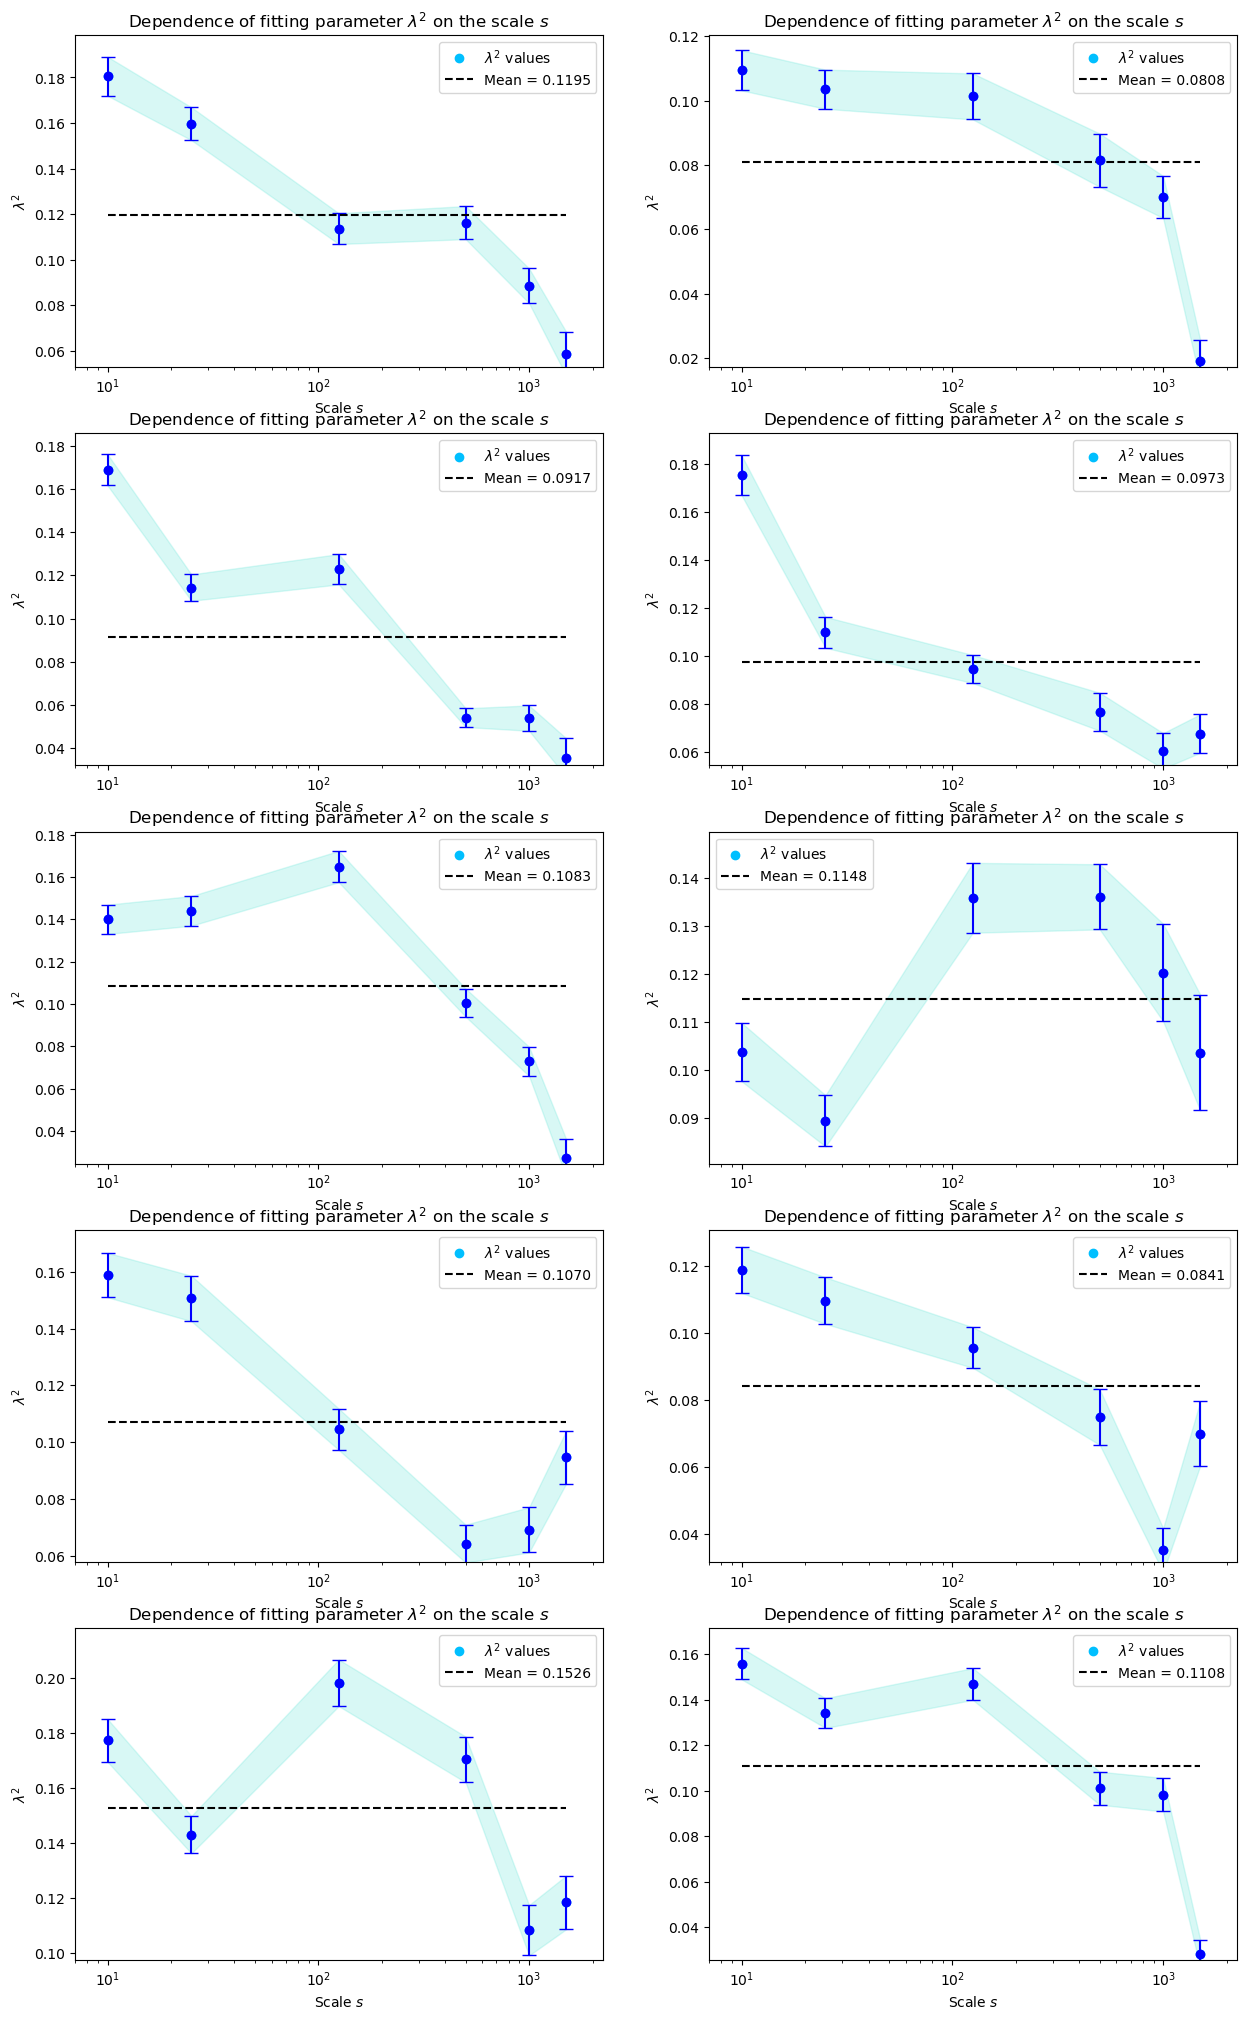

In [15]:
plt.figure(figsize=(15, 25))  

for i in range(len(lambda_all)):
    lambdas = lambda_all[i]
    lambdas_err = lambda_err_all[i]
    
    lambdas_sqr = lambdas ** 2
    lambdas_err_sqr = 2 * lambdas * lambdas_err
    mean_lambda_sqr = lambdas_sqr.mean()

    plt.subplot(5,2,i+1)

    plt.xscale("log")
    
    plt.ylim([min(lambdas_sqr) * 0.9, max(lambdas_sqr) * 1.1])
    plt.xlim([min(s_list) * 0.7, max(s_list) * 1.5])

    plt.plot(s_list, lambdas_sqr, 'o', color='deepskyblue', label=r"$\lambda^2$ values")

    # Plot the error range for lambda^2
    plt.fill_between(s_list,
                    lambdas_sqr - lambdas_err_sqr,
                    lambdas_sqr + lambdas_err_sqr,
                    alpha=0.2, color='turquoise')

    plt.errorbar(s_list, lambdas_sqr, yerr=lambdas_err_sqr, fmt='o', capsize=5, color='blue')

    plt.hlines(mean_lambda_sqr, min(s_list), max(s_list), colors="k", linestyles="--", label=f"Mean = {mean_lambda_sqr:.4f}")

    plt.title(r"Dependence of fitting parameter $\lambda^2$ on the scale $s$")
    plt.xlabel(r"Scale $s$")
    plt.ylabel(r"$\lambda^2$")

    plt.legend()

plt.show()

As we see from the result, lambda has a decreasing trend when the time scale increases.

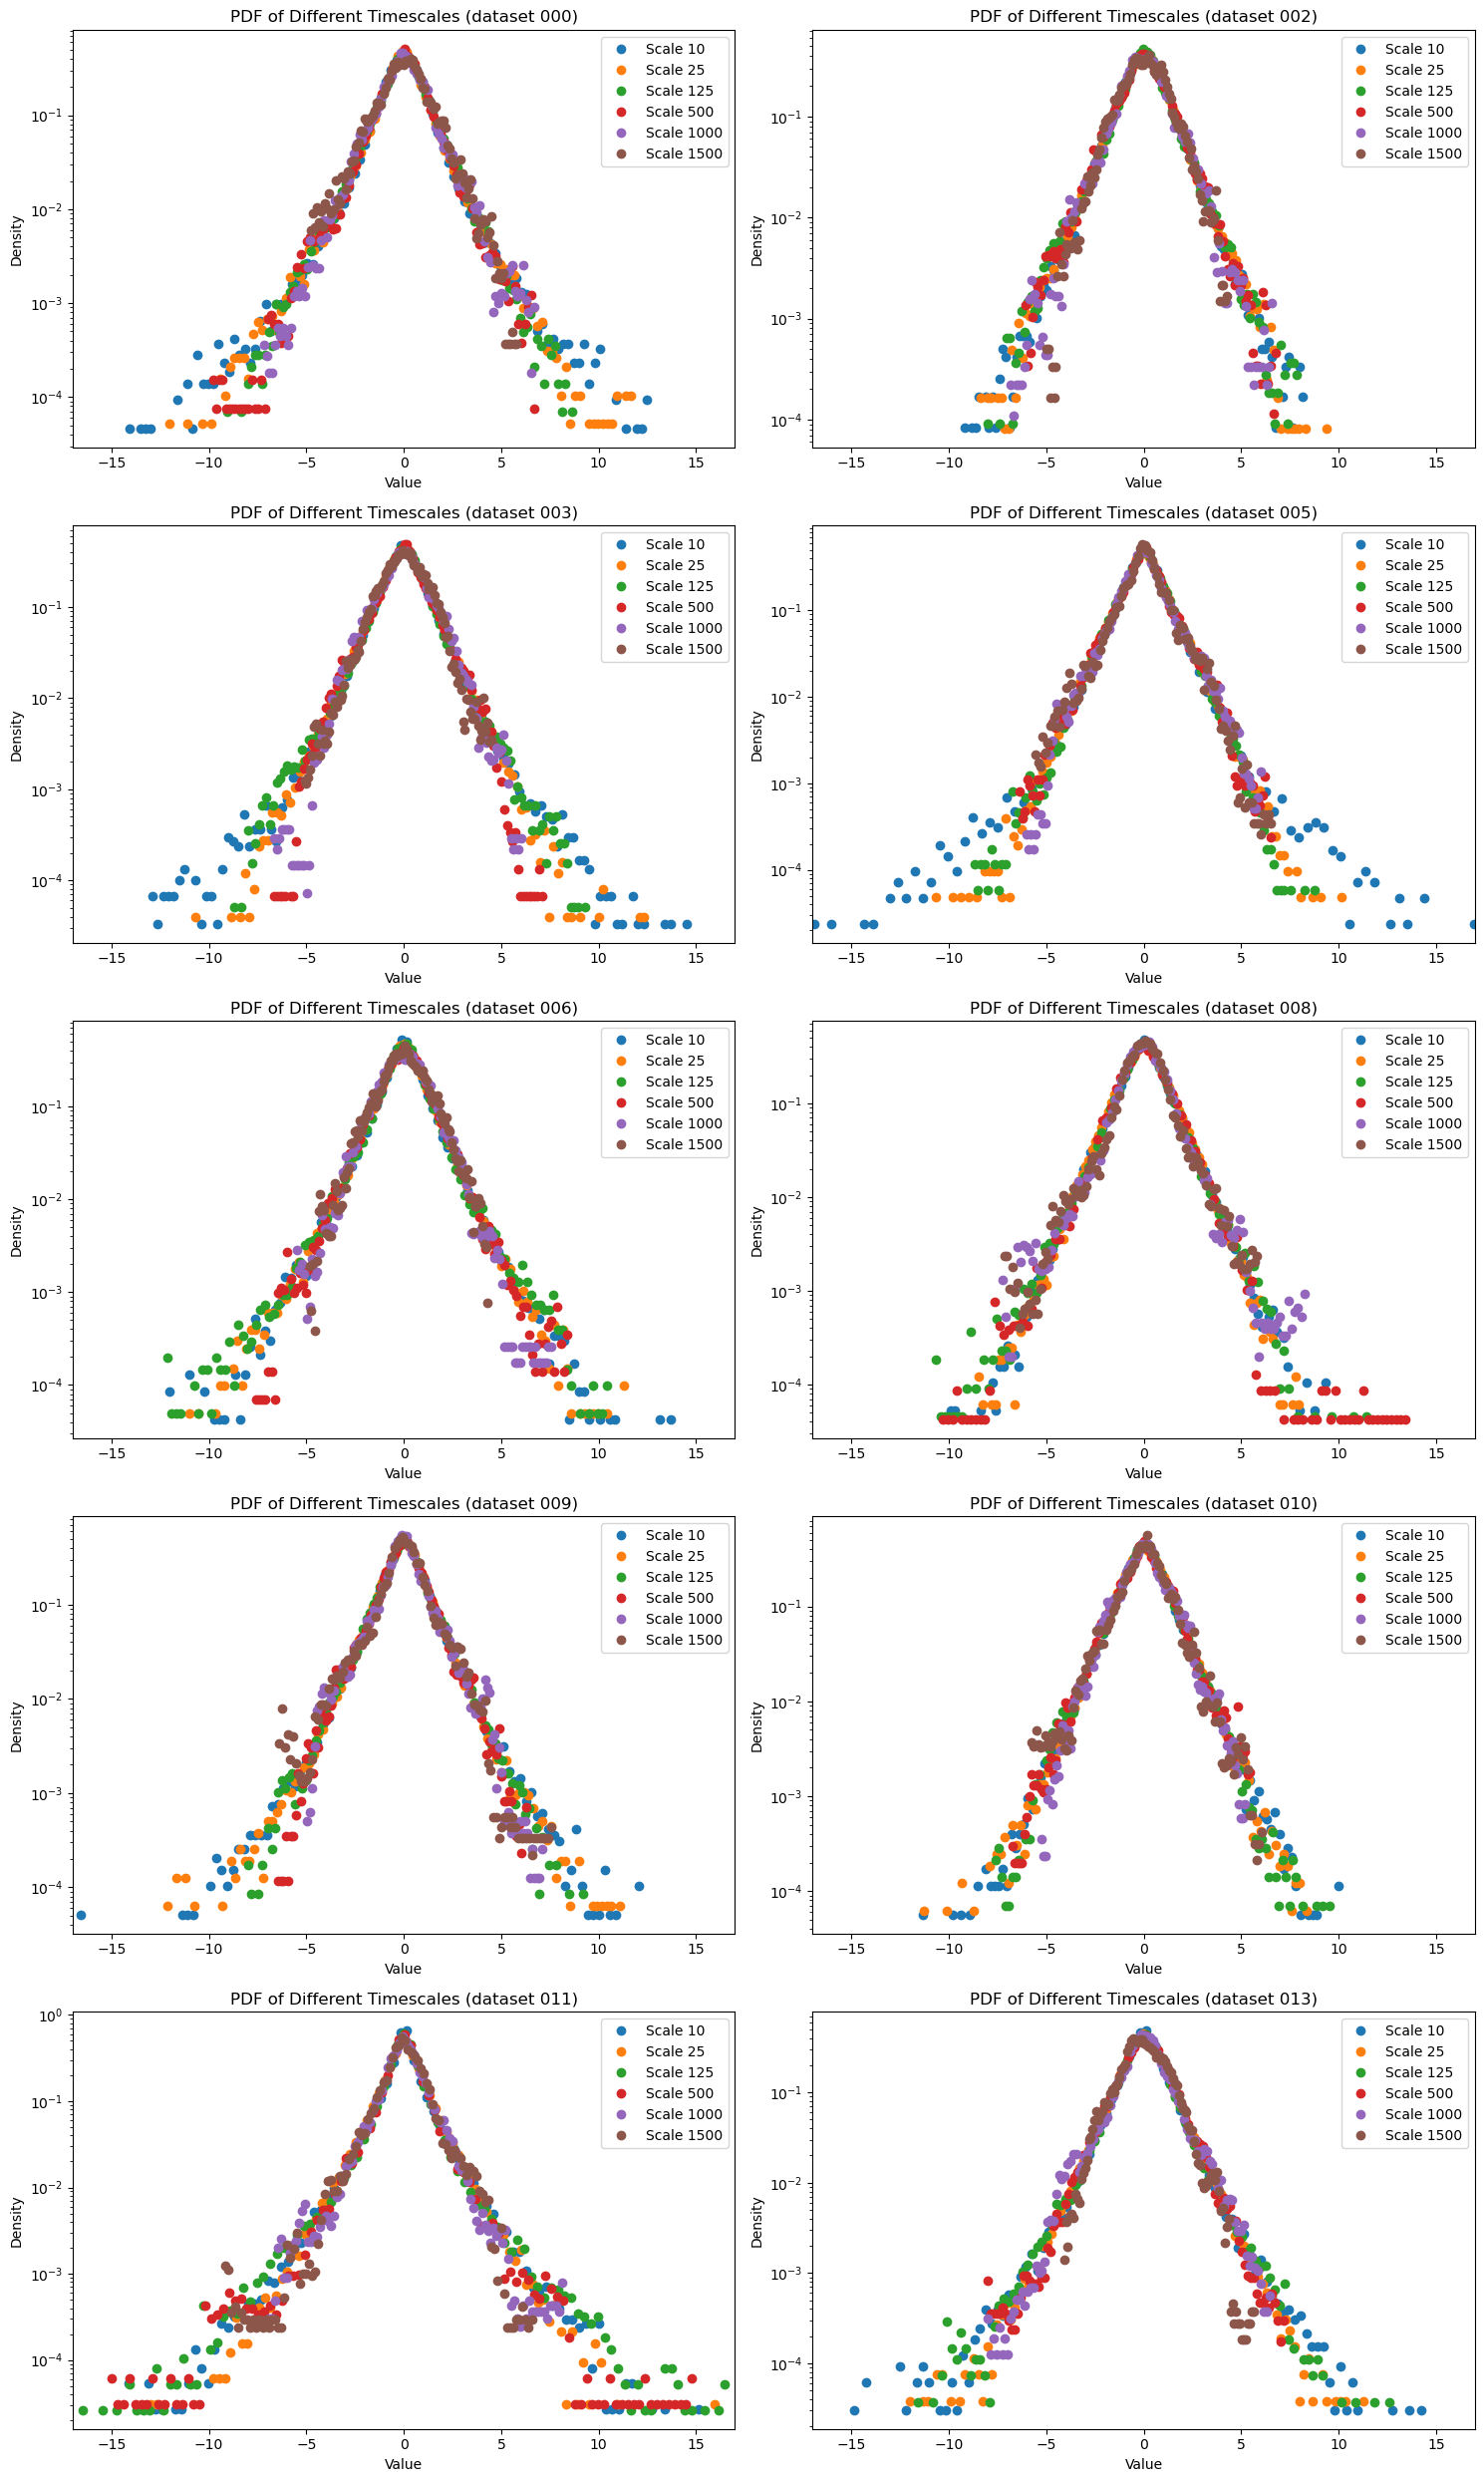

In [16]:
plt.figure(figsize=(15, 25))  

for i in range(len(data_name)):
    dataset = deltaBs[i]
    
    for j in range(len(s_list)):
        data = dataset.iloc[j].dropna().to_numpy() # convert the data into Numpy array and remove NaN values

        # plot the histogram of the data
        density, bins = np.histogram(data, bins=100, density=True)
        centers = (bins[:-1] + bins[1:]) / 2  # Get bin centers
        plt.subplot(5,2,i+1)
        plt.plot(centers, density, "o",label=f"Scale {s_list[j]}")  # Line plot for density
        plt.yscale("log")
        plt.xlim(-17,17)
        plt.title(f"PDF of Different Timescales (dataset {data_name[i]})")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
plt.tight_layout()
plt.show()
